In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)
/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-9494aff0-1a8d-4b91-8b3d-3bc8c5056729.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.6.0' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
ERROR 
################################################################################
cmd='(git log --date=local --oneline --graph --date-order --decorate --pretty=format:'%h %<(8)%aN%  %<(65)%s (%>(14)%ar) %ad %<(10)%d' -3) 2>&1' failed with rc='128'
################################################################################
Output of the failing command is:
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
fatal

# Build the config

In [4]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    amp_dir,
    "dataflow/model/test/outcomes/Test_run_master_research_backtest_analyzer/input/tiled_results",
)
config = {
    "dir_name": dir_name,
    "start_date": datetime.date(2000, 1, 1),
    "end_date": datetime.date(2000, 1, 31),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "15T",
    "annotate_forecasts_kwargs": {
        "style": "longitudinal",
        "quantization": 30,
        "liquidate_at_end_of_day": False,
        "initialize_beginning_of_day_trades_to_zero": False,
        "burn_in_bars": 3,
        "compute_extended_stats": True,
        "target_dollar_risk_per_name": 1e2,
        "modulate_using_prediction_magnitude": True,
    },
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "vwap.ret_0.vol",
        "prediction_col": "prediction",
    },
    "bin_annotated_portfolio_df_kwargs": {
        "proportion_of_data_per_bin": 0.2,
        "normalize_prediction_col_values": False,
    },
}
config = cconfig.Config().from_dict(config)
print(config)

ERROR While executing 'get_extra_amp_repo_sym_name()' caught error:
name 'get_extra_amp_repo_sym_name' is not defined
Trying to continue
dir_name: /app/amp/dataflow/model/test/outcomes/Test_run_master_research_backtest_analyzer/input/tiled_results
start_date: 2000-01-01
end_date: 2000-01-31
asset_id_col: asset_id
pnl_resampling_frequency: 15T
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 100.0
  modulate_using_prediction_magnitude: True
column_names: 
  price_col: vwap
  volatility_col: vwap.ret_0.vol
  prediction_col: prediction
bin_annotated_portfolio_df_kwargs: 
  proportion_of_data_per_bin: 0.2
  normalize_prediction_col_values: False


# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1467591036,1,1,1,12.4 KB
3303714233,1,1,1,12.4 KB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

,,n_asset_ids,size
year,month,,
2000,1,2,24.8 KB


In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1467591036, 3303714233]

## Load a single-asset tile

In [9]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [11]:
single_tile_df.columns.levels[0].to_list()

['close',
 'close.ret_0',
 'feature1',
 'month',
 'prediction',
 'twap',
 'twap.ret_0',
 'vwap',
 'vwap.ret_0',
 'vwap.ret_0.vol',
 'vwap.ret_0.vol_adj',
 'vwap.ret_0.vol_adj.c',
 'vwap.ret_0.vol_adj.c.lag0',
 'vwap.ret_0.vol_adj.c.lag1',
 'vwap.ret_0.vol_adj.c.lag2',
 'vwap.ret_0.vol_adj.c.lag3',
 'year']

In [12]:
single_tile_df.head(3)

,close,close.ret_0,feature1,month,prediction,twap,twap.ret_0,vwap,vwap.ret_0,vwap.ret_0.vol,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,vwap.ret_0.vol_adj.c.lag0,vwap.ret_0.vol_adj.c.lag1,vwap.ret_0.vol_adj.c.lag2,vwap.ret_0.vol_adj.c.lag3,year
asset_id,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036
end_ts,,,,,,,,,,,,,,,,,
2000-01-01 14:35:00+00:00,101.0,NaN,1.0,1,NaN,101.0,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000
2000-01-01 14:40:00+00:00,100.0,-0.00995,-1.0,1,NaN,100.0,-0.00995,100.0,-0.00995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000
2000-01-01 14:45:00+00:00,101.0,0.00995,1.0,1,NaN,101.0,0.00995,101.0,0.00995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000


# Compute portfolio bar metrics

In [13]:
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    asset_ids=None,
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
    return_portfolio_df=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100


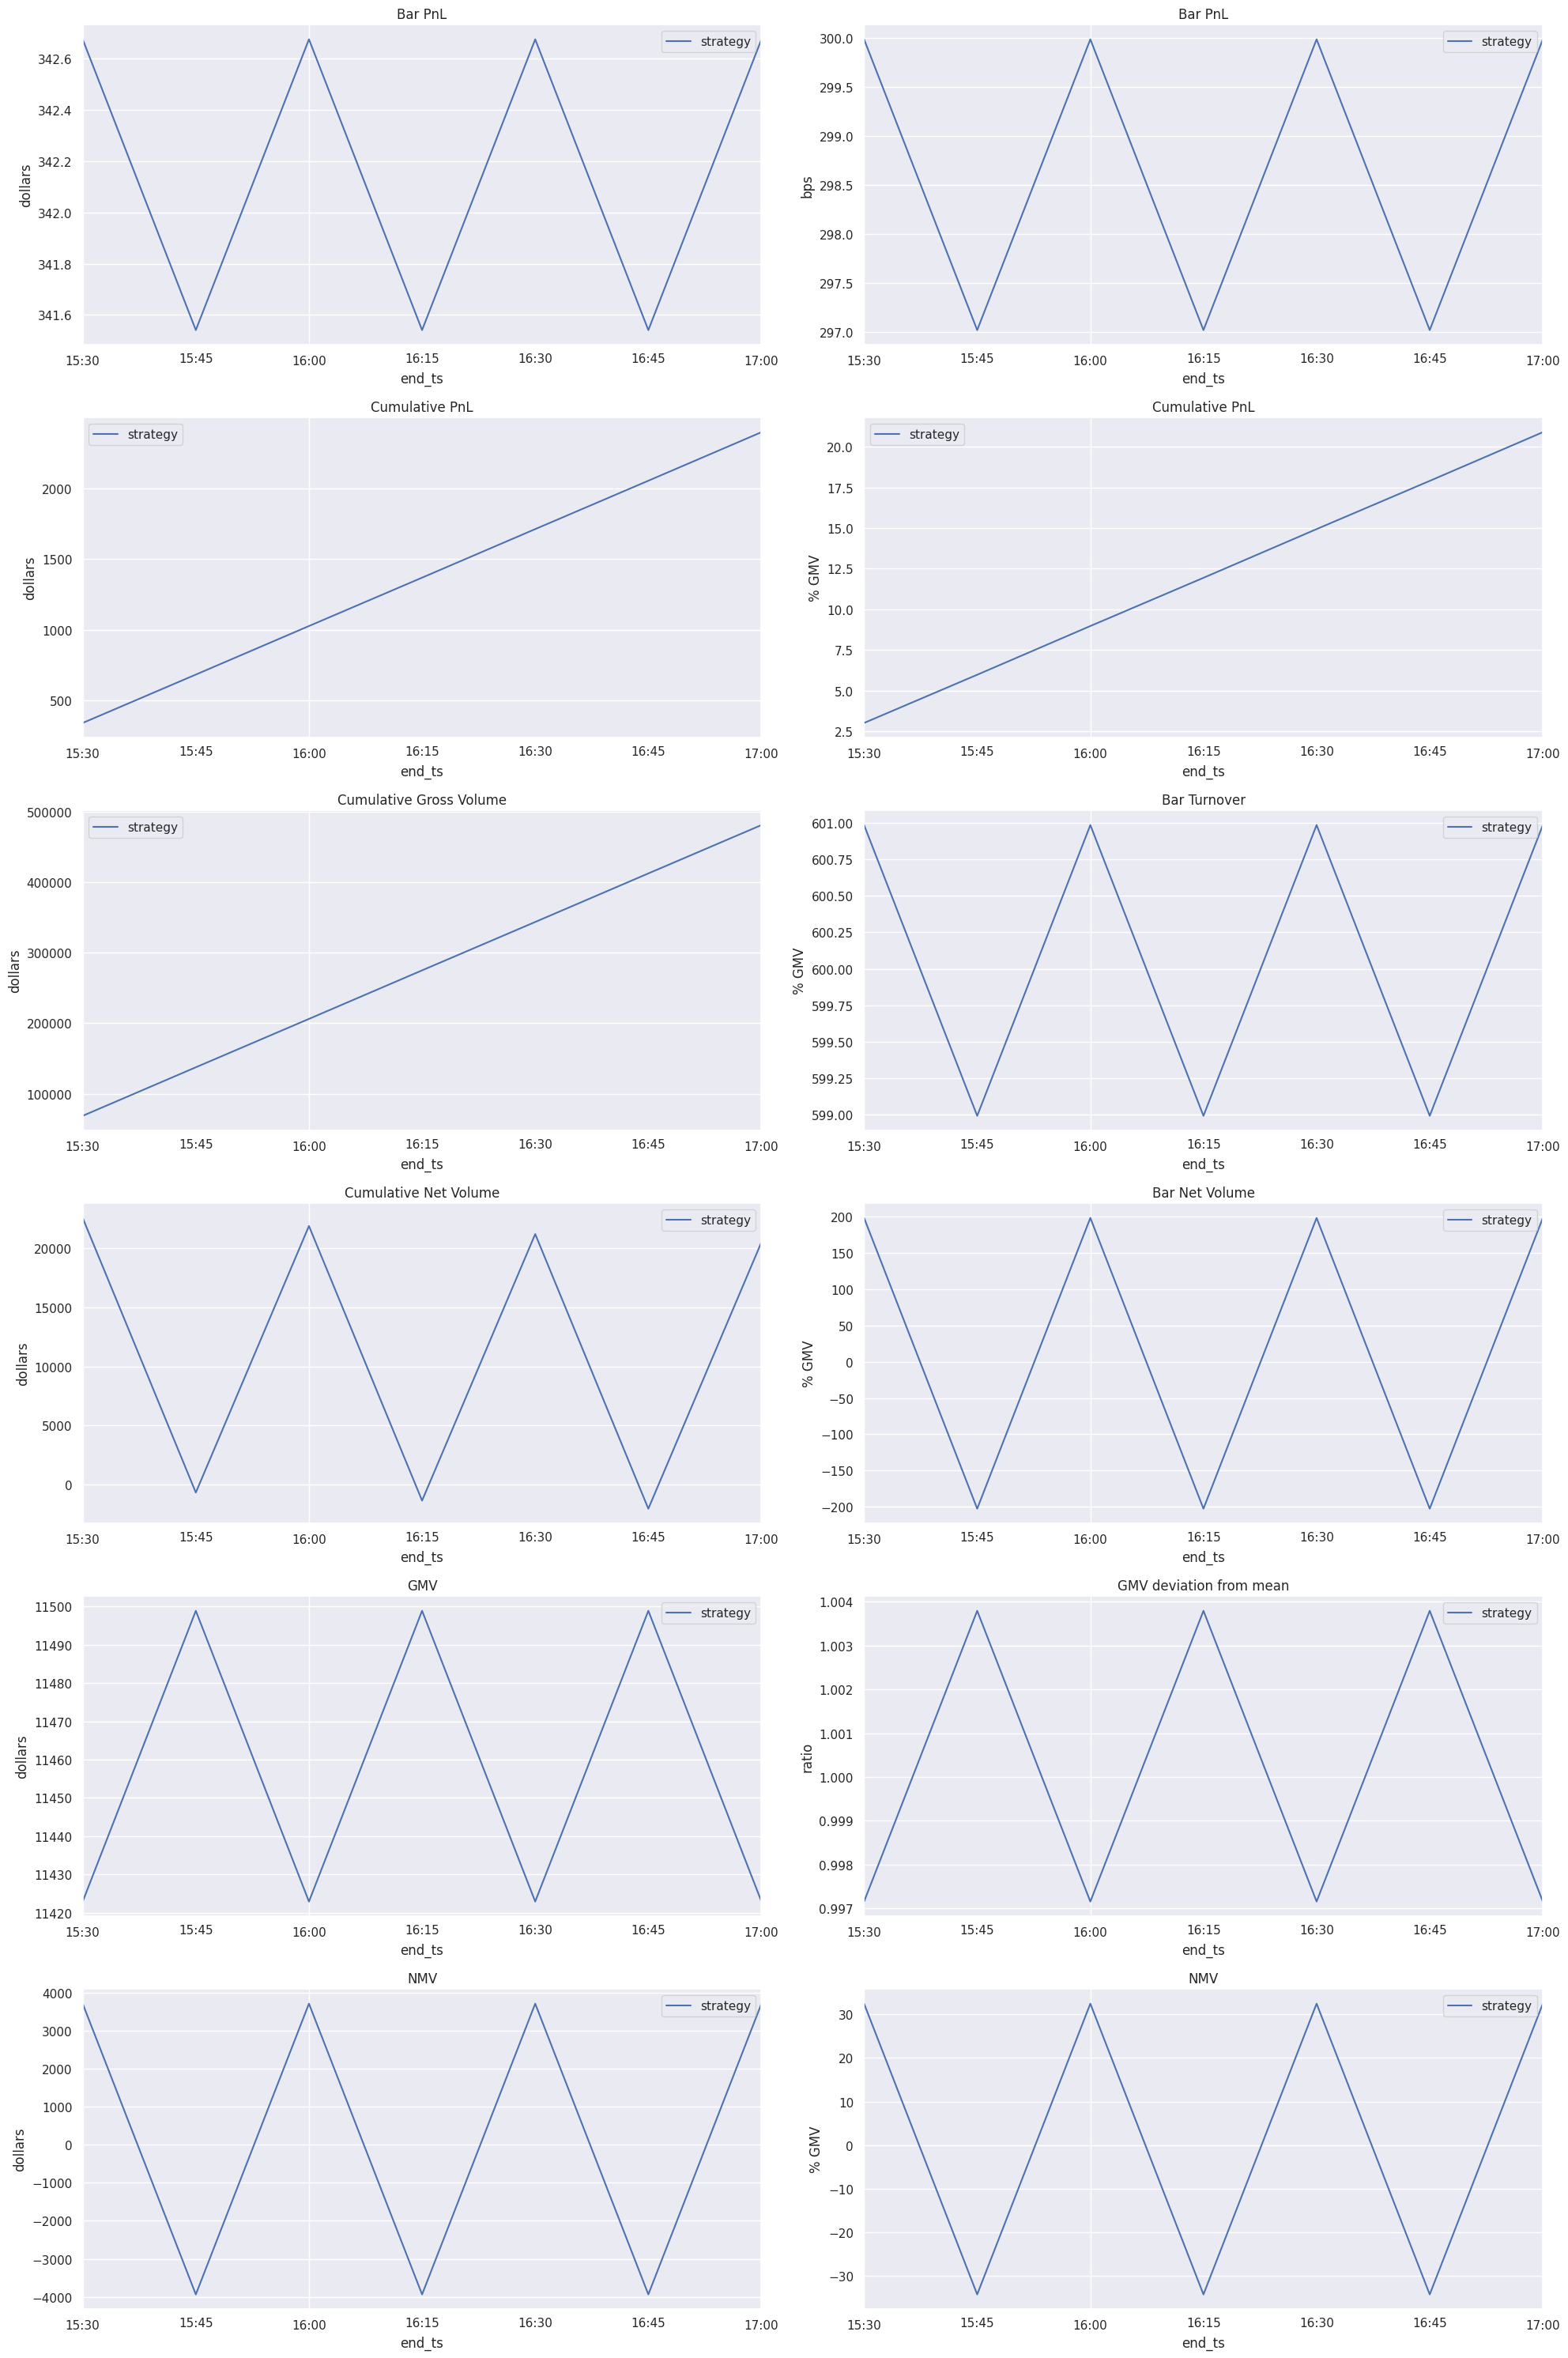

In [14]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

In [15]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["column_names"],
)

<AxesSubplot: title={'center': 'pnl'}, xlabel='prediction'>

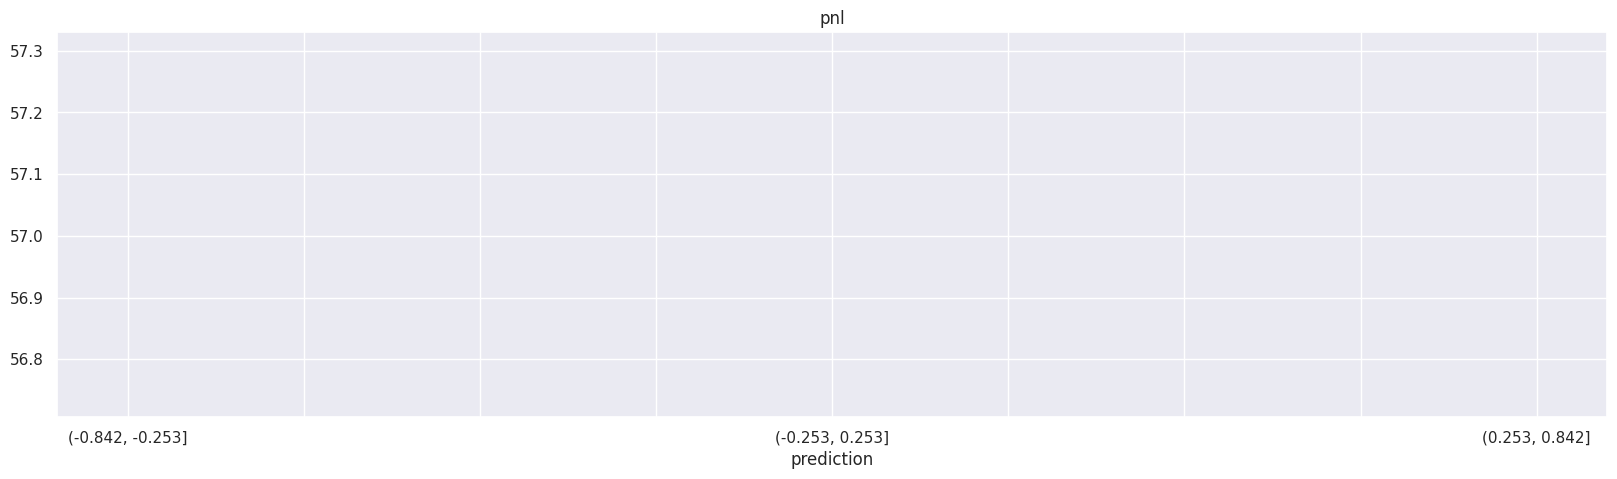

In [16]:
output_col = "pnl"
binned_df = fep.bin_annotated_portfolio_df(
    portfolio_df, output_col=output_col, **config["bin_annotated_portfolio_df_kwargs"],
)
binned_df["mean"].mean(axis=1).plot(title=output_col)

<AxesSubplot: title={'center': 'pnl_in_bps'}, xlabel='prediction'>

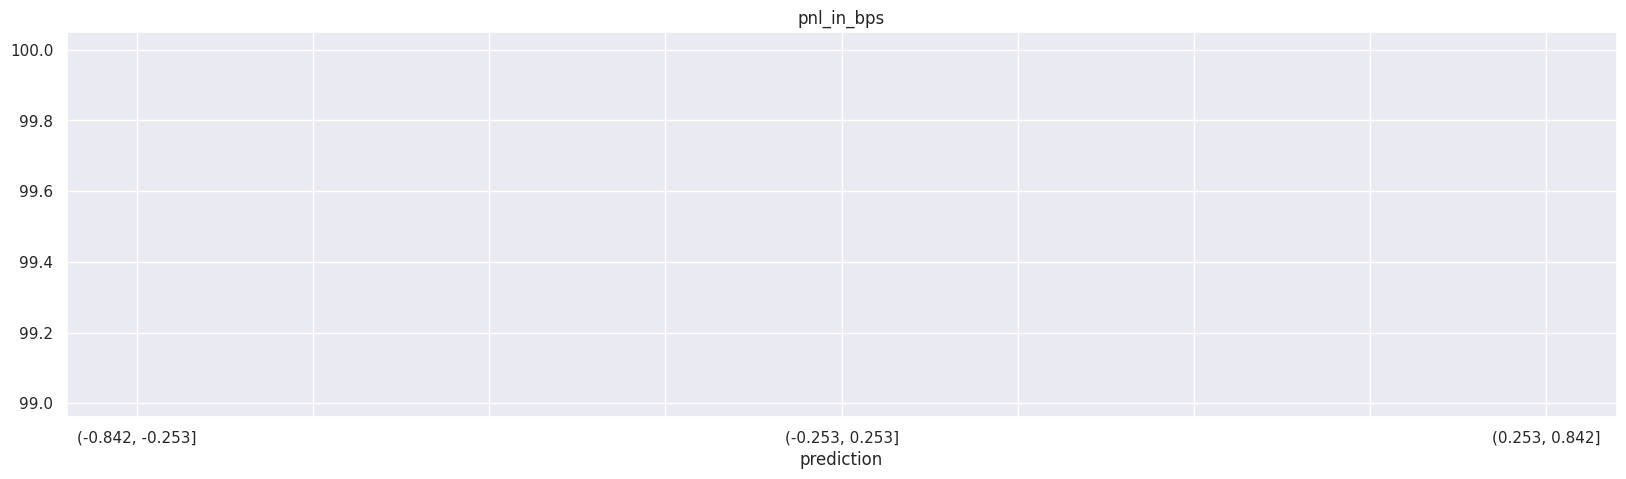

In [17]:
output_col = "pnl_in_bps"
binned_df = fep.bin_annotated_portfolio_df(
    portfolio_df, output_col=output_col, **config["bin_annotated_portfolio_df_kwargs"],
)
binned_df["mean"].mean(axis=1).plot(title=output_col)

<AxesSubplot: title={'center': 'sgn_corr'}, xlabel='prediction'>

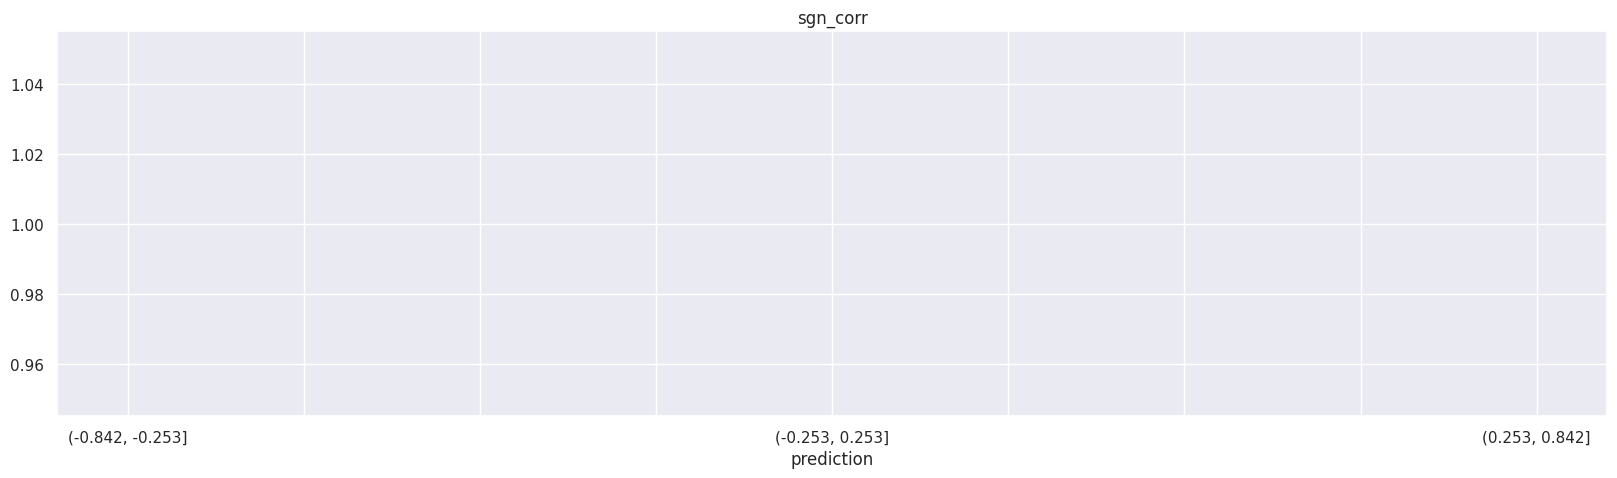

In [18]:
output_col = "sgn_corr"
binned_df = fep.bin_annotated_portfolio_df(
    portfolio_df, output_col=output_col, **config["bin_annotated_portfolio_df_kwargs"],
)
binned_df["mean"].mean(axis=1).plot(title=output_col)

<AxesSubplot: title={'center': 'hit_rate'}, xlabel='prediction'>

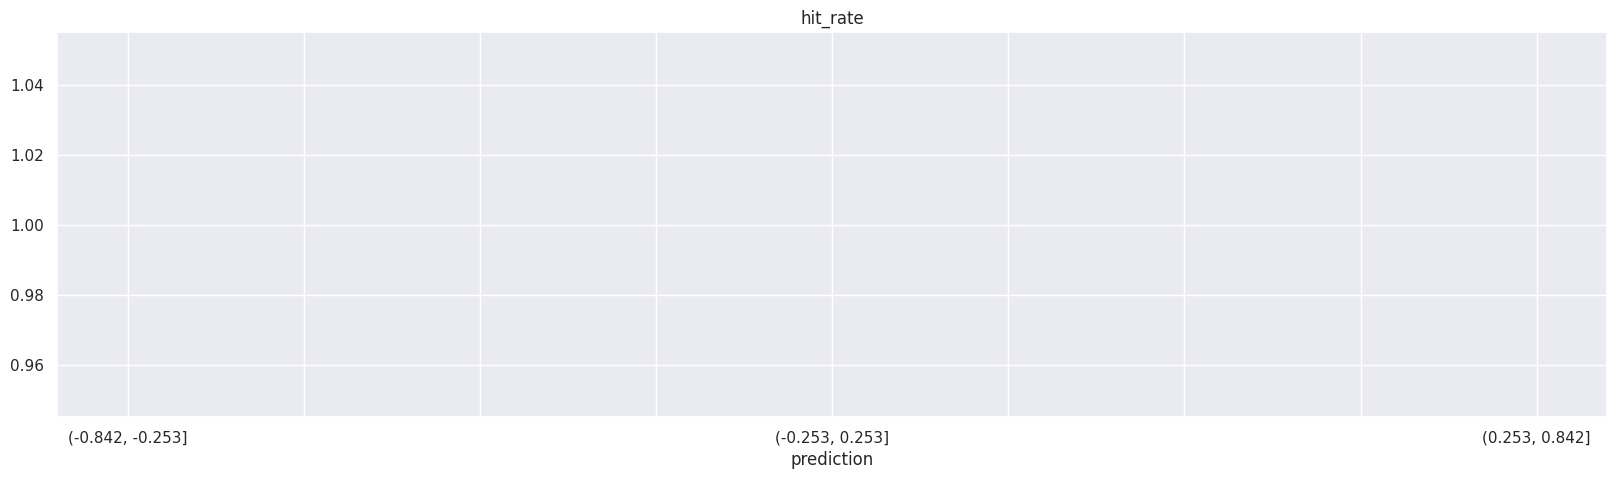

In [19]:
output_col = "hit_rate"
binned_df = fep.bin_annotated_portfolio_df(
    portfolio_df, output_col=output_col, **config["bin_annotated_portfolio_df_kwargs"],
)
binned_df["mean"].mean(axis=1).plot(title=output_col)

# Compute aggregate portfolio stats

In [20]:
stats_computer = dtfmod.StatsComputer()

In [21]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["pnl_resampling_frequency"],
)
display(portfolio_stats)

ratios      sharpe_ratio                     105628.57
            sharpe_ratio_standard_error       30492.44
            sr.tval                            1492.70
            sr.pval                               0.00
            kratio                           145746.74
dollar      gmv_mean                          11455.47
            gmv_stdev                            40.64
            annualized_mean_return         11994454.47
            annualized_volatility               113.55
            max_drawdown                          0.00
            pnl_mean                            342.19
            pnl_std                               0.61
            turnover_mean                     68747.42
            turnover_stdev                      121.91
            market_bias_mean                    431.72
            market_bias_stdev                  4084.07
percentage  annualized_mean_return           104705.02
            annualized_volatility                 0.99
          